# 1. Problem Definition

## 1.1 Project Goal
The primary aim of this project is to create a machine learning solution that can accurately identify and classify individual butterfly images into one of 75 unique species. This automated classification system is intended to support biodiversity research and conservation by providing a tool for rapid and reliable species identification.

## 1.2 Problem Statement
The task at hand is a multi-class image classification problem, where the challenge is to design a model that can interpret visual inputs (butterfly images) and correctly assign each image to a specific species label. The model must be able to handle the complexity of natural image variations and deliver high accuracy to be practically useful for researchers and enthusiasts.

## 1.3 Specific Challenges
**High Variability:** The natural world presents high variability within species, including differences in wing patterns, coloration, and scale, which the model must account for.

**Subtle Differences:** Some butterfly species may have only subtle differences between them, requiring the model to learn fine-grained visual distinctions.

**Data Quality and Diversity:** The dataset's images may vary in terms of quality, angle, lighting, and background, which can affect the model's learning process.

**Class Imbalance:** The dataset may have an uneven distribution of images across the 75 species, with some species having many images and others having few, potentially leading to a model bias towards the more represented classes.

## 1.4 Desired Model Characteristics
The model should ideally possess the following characteristics:

**Accuracy:** High classification accuracy across all 75 species.
**Robustness:** Ability to handle intra-class variation and inter-class similarity effectively.
**Generalization:** Capability to perform well on unseen data, indicating strong generalization from the training dataset.
**Scalability:** Flexibility to accommodate additional data or classes in the future without significant retraining or restructuring.

## 1.5 Impact of the Solution
A successful classification model will significantly enhance the efficiency of species identification processes, contributing to ecological studies, conservation efforts, and educational outreach. By automating the identification process, we can facilitate larger-scale data analysis and foster greater engagement with biodiversity data.

# 2. Data Collection

## 2.1 Source of Data
The dataset is sourced from AI Planet's Data Sprint 107 - Butterfly Identification challenge, which can be found at the following URL: https://aiplanet.com/challenges/325/butterfly_identification/data

## 2.2 Composition of the Dataset
The dataset consists of 6499 labeled images, each representing one of 75 distinct butterfly species. The images are carefully labeled to ensure that each corresponds to the correct species, providing a reliable ground truth for training and validating classification models.

## 2.3 Data Organization
Image files are organized into one folder, where each image is titled: "Image_#.jpg" where # is the image number. The labels are saved in a CSV file titled: labels.csv containing a filename column with each "Image_#.jpg" and its class under the label column.

# 3. Data Preprocessing

## 3.1 Loading the Labels and Visualizing the Images

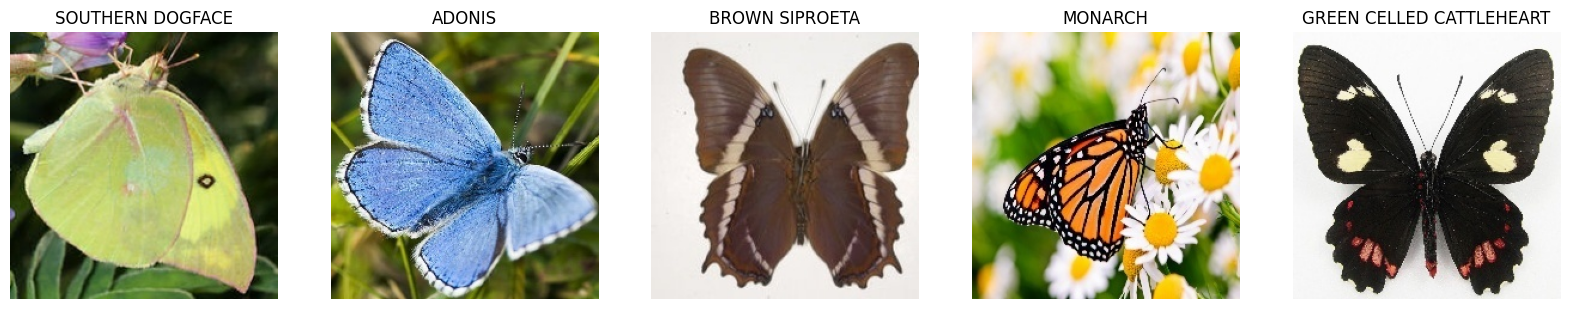

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

labels_path = 'labels.csv'
images_directory = 'data/'
# Set the model save path
model_save_path = '/content/drive/My Drive/butterfly_model_directory_w_Aug/'

# Load the labels
labels_df = pd.read_csv(labels_path)

# Display the first 5 images and their labels
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, (index, row) in enumerate(labels_df.iterrows()):
    if i == 5:  # Only display 5 images
        break
    img_path = os.path.join(images_directory, row['filename'])
    image = Image.open(img_path)
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(row['label'])

plt.show()

## 3.2 Visualizing the Class Distribution

In [4]:
# Print the number of unique classes
num_classes = labels_df['label'].nunique()
print(f"The dataset contains {num_classes} unique butterfly classes.")

# pd.set_option('display.max_rows', None) #To display all rows

# Count the number of images per class
class_distribution = labels_df['label'].value_counts()
#print(class_distribution)
"""
# Plot the distribution
plt.figure(figsize=(20, 10))
class_distribution.plot(kind='bar')
plt.title('Distribution of Butterfly Classes')
plt.xlabel('Butterfly Species')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)  # Rotate x-axis labels to show them clearly
plt.show()
"""

The dataset contains 75 unique butterfly classes.


"\n# Plot the distribution\nplt.figure(figsize=(20, 10))\nclass_distribution.plot(kind='bar')\nplt.title('Distribution of Butterfly Classes')\nplt.xlabel('Butterfly Species')\nplt.ylabel('Number of Images')\nplt.xticks(rotation=90)  # Rotate x-axis labels to show them clearly\nplt.show()\n"

![Class Distribution](https://i.imgur.com/XBEFPkQ.png)


### Analysis of Class Distribution
The butterfly dataset is well-balanced across 75 classes, with a slight variation in image count ranging from 71 to 131 per class. This setup is good for training a classification model, with enough data for each class and no severe imbalances to address.

# 3.3 Data Splitting into TvT (Train, validation, Test split)

The split chosen is: **60/20/20**

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training+validation and testing sets
train_val_df, test_df = train_test_split(
    labels_df, test_size=0.2, random_state=7)

# Split the training+validation set into training and validation sets
train_df, valid_df = train_test_split(
    train_val_df, test_size=0.25, random_state=77)

## 3.4 Defining the Augmentation parameters

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

preprocess_input = None #preprocessing function for the selected model

# Add data augmentation parameters to the training data generator
datagen_train = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

datagen_valid_test = ImageDataGenerator(preprocessing_function=preprocess_input)

## 3.5 Initializing the Data Generators

In [31]:
# Define the image size and batch size
image_size = (224, 224) 
batch_size = 32

# Normalizing the images
datagen = ImageDataGenerator(rescale=1./255) 

# Create the training, validation, and testing data generators
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    directory=images_directory,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = datagen_valid_test.flow_from_dataframe(
    dataframe=valid_df,
    directory=images_directory,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=images_directory,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Using 'categorical' because more than two classes
    shuffle=False  # Do not shuffle for testing
)

Found 3899 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam



# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_df.shape[0] // batch_size,
    epochs=1,  # Adjust the number of epochs based on your dataset and training time
    validation_data=validation_generator,
    validation_steps=valid_df.shape[0] // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=np.ceil(test_df.shape[0] / batch_size)
)

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

Found 3899 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


41/41 [==============================] - 873s 22s/step - loss: 0.8419 - accuracy: 0.7454
Test loss: 0.8419113159179688
Test accuracy: 0.7453846335411072


sample of data

In [ ]:
# Load the labels
labels_df_sample = labels_df.sample(n=500, random_state=777)

# Ensure that each class has at least one image
min_images_per_class = max(labels_df['label'].value_counts().min(), 1)

# Create a StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=500, random_state=777)

# Perform the split
for train_index, test_index in sss.split(labels_df, labels_df['label']):
    labels_df_sample = labels_df.iloc[test_index]

# Check if all classes are present
assert labels_df_sample['label'].nunique() == labels_df['label'].nunique()

# Now, split the sampled data into training+validation and testing sets
train_val_df, test_df = train_test_split(labels_df_sample, test_size=0.2, stratify=labels_df_sample['label'], random_state=7)

# Split the training+validation set into training and validation sets
train_df, valid_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['label'], random_state=77)

Regularization, learning rate scheduling, batch normalization, and early stopping (NO AUGMENTATION)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # Import the preprocess_input

# Load the labels
labels_df = pd.read_csv(labels_path)

# Split the data into training+validation and testing sets
train_val_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=7)

# Split the training+validation set into training and validation sets
train_df, valid_df = train_test_split(train_val_df, test_size=0.25, random_state=77)

# Define the image size and batch size
image_size = (224, 224)  # Updated to match your dataset's resolution
batch_size = 32

# Initialize the data generators with preprocessing function for MobileNetV2
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNetV2's preprocessing
    # Add data augmentation parameters here if needed
)

datagen_valid_test = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create the data generators
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    directory=images_directory,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = datagen_valid_test.flow_from_dataframe(
    dataframe=valid_df,
    directory=images_directory,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen_valid_test.flow_from_dataframe(
    dataframe=test_df,
    directory=images_directory,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of MobileNetV2 with BatchNormalization and Dropout for regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Add BatchNormalization
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a learning rate scheduler
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    model_save_path + 'model_epoch_{epoch:02d}.h5',  # Save path with epoch number
    monitor='val_loss',            # The metric to monitor
    save_best_only=False,          # If False, saves the model after every epoch regardless of the metric
    save_weights_only=False,       # If True, saves only the weights, else saves the full model
    verbose=1                      # Verbosity mode
)
# Train the model with the new callbacks including ModelCheckpoint
history = model.fit(
    train_generator,
    steps_per_epoch=train_df.shape[0] // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=valid_df.shape[0] // batch_size,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]  # Add model_checkpoint here
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_df.shape[0] // batch_size
)

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

Found 3899 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
Epoch 1/100
121/121 [==============================] - ETA: 0s - loss: 3.8360 - accuracy: 0.1490
Epoch 1: saving model to /content/drive/My Drive/butterfly_model_directory/model_epoch_01.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/121 [==============================] - 1323s 11s/step - loss: 3.8360 - accuracy: 0.1490 - val_loss: 2.8023 - val_accuracy: 0.5125 - lr: 1.0000e-04
Epoch 2/100
121/121 [==============================] - ETA: 0s - loss: 2.0577 - accuracy: 0.5045
Epoch 2: saving model to /content/drive/My Drive/butterfly_model_directory/model_epoch_02.h5
121/121 [==============================] - 25s 210ms/step - loss: 2.0577 - accuracy: 0.5045 - val_loss: 1.6835 - val_accuracy: 0.6922 - lr: 1.0000e-04
Epoch 3/100
121/121 [==============================] - ETA: 0s - loss: 1.3174 - accuracy: 0.6786
Epoch 3: saving model to /content/drive/My Drive/butterfly_model_directory/model_epoch_03.h5
121/121 [==============================] - 26s 216ms/step - loss: 1.3174 - accuracy: 0.6786 - val_loss: 1.1832 - val_accuracy: 0.7391 - lr: 1.0000e-04
Epoch 4/100
121/121 [==============================] - ETA: 0s - loss: 0.9525 - accuracy: 0.7673
Epoch 4: saving model to /content/drive/My Drive/butterfly_model_direc

Same as before WITH AUGMENTATION

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # Import the preprocess_input

# Load the labels
labels_df = pd.read_csv(labels_path)

# Split the data into training+validation and testing sets
train_val_df, test_df = train_test_split(labels_df, test_size=0.2, random_state=7)

# Split the training+validation set into training and validation sets
train_df, valid_df = train_test_split(train_val_df, test_size=0.25, random_state=77)

# Define the image size and batch size
image_size = (224, 224)  # Updated to match your dataset's resolution
batch_size = 32

# Initialize the data generators with preprocessing function for MobileNetV2
datagen_train = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

datagen_valid_test = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create the data generators
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    directory=images_directory,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = datagen_valid_test.flow_from_dataframe(
    dataframe=valid_df,
    directory=images_directory,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen_valid_test.flow_from_dataframe(
    dataframe=test_df,
    directory=images_directory,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of MobileNetV2 with BatchNormalization and Dropout for regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Add BatchNormalization
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a learning rate scheduler
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    model_save_path + 'model_epoch_{epoch:02d}.h5',  # Save path with epoch number
    monitor='val_loss',            # The metric to monitor
    save_best_only=False,          # If False, saves the model after every epoch regardless of the metric
    save_weights_only=False,       # If True, saves only the weights, else saves the full model
    verbose=1                      # Verbosity mode
)
# Train the model with the new callbacks including ModelCheckpoint
history = model.fit(
    train_generator,
    steps_per_epoch=train_df.shape[0] // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=valid_df.shape[0] // batch_size,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]  # Add model_checkpoint here
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_df.shape[0] // batch_size
)

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

Found 3899 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/100
121/121 [==============================] - ETA: 0s - loss: 3.9622 - accuracy: 0.1265
Epoch 1: saving model to /content/drive/My Drive/butterfly_model_directory/model_epoch_01.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/121 [==============================] - 1522s 13s/step - loss: 3.9622 - accuracy: 0.1265 - val_loss: 2.8969 - val_accuracy: 0.4734 - lr: 1.0000e-04
Epoch 2/100
121/121 [==============================] - ETA: 0s - loss: 2.3724 - accuracy: 0.4213
Epoch 2: saving model to /content/drive/My Drive/butterfly_model_directory/model_epoch_02.h5
121/121 [==============================] - 76s 630ms/step - loss: 2.3724 - accuracy: 0.4213 - val_loss: 1.8197 - val_accuracy: 0.6492 - lr: 1.0000e-04
Epoch 3/100
121/121 [==============================] - ETA: 0s - loss: 1.6992 - accuracy: 0.5834
Epoch 3: saving model to /content/drive/My Drive/butterfly_model_directory/model_epoch_03.h5
121/121 [==============================] - 82s 672ms/step - loss: 1.6992 - accuracy: 0.5834 - val_loss: 1.2810 - val_accuracy: 0.7305 - lr: 1.0000e-04
Epoch 4/100
121/121 [==============================] - ETA: 0s - loss: 1.3371 - accuracy: 0.6504
Epoch 4: saving model to /content/drive/My Drive/butterfly_model_direc

# 4 Choosing a Model Architecture

# 5 Training the Model

# 6 Evaluating the Model